## RATINGS PREDICTION PROJECT
Problem Statement:


We have a client who has a website where people write different reviews for technical products. Now they are adding a new feature to their website i.e. the reviewer will have to add stars (ratings) as well with the review. The rating is out 5 stars and it only has 5 options available 1 star, 2 stars, 3 stars, 4 stars and 5 stars. Now they want to predict ratings for the reviews which were written in the past and they don’t have a rating. So, we have to build an application which can predict the rating by seeing the review.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Importing nltk libraries
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import FreqDist

from scipy import stats
from scipy.stats import zscore
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, confusion_matrix, accuracy_score, classification_report

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

lemmatizer = nltk.stem.WordNetLemmatizer()

In [2]:
df = pd.read_csv("Rating_Scrapping_data.csv")
df # checking the first five and last five rows of our dataset

,Unnamed: 0,Product_Review,Ratings
0,0,It has great sound quality and bass but after ...,1.0
1,1,"[BIG UPDATE]IT BROKE ALONG THE RIGHT HINGE, I ...",2.0
2,2,This is a premium quality product from boAt-Li...,5.0
3,3,The boAt Rockerz line is boAt's super cheap li...,1.0
4,4,Material is very poor quality but service also...,5.0
...,...,...,...
48045,48045,Battery and phone burnt while charging,1.0
48046,48046,Phone is not so good as expected just say one ...,1.0
48047,48047,It's a worst phone,1.0
48048,48048,"This product is good, it's ultra slim, though ...",5.0


In [3]:
df.isna().sum() # checking for missing values

Unnamed: 0          0
Product_Review    350
Ratings             0
dtype: int64

In [4]:
print("We have {} Rows and {} Columns in our dataframe before removing NaN".format(df.shape[0], df.shape[1]))
df.dropna(inplace=True)
print("We have {} Rows and {} Columns in our dataframe after removing NaN".format(df.shape[0], df.shape[1]))

We have 48050 Rows and 3 Columns in our dataframe before removing NaN
We have 47700 Rows and 3 Columns in our dataframe after removing NaN


In [5]:
df.isnull().sum()

Unnamed: 0        0
Product_Review    0
Ratings           0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47700 entries, 0 to 48049
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      47700 non-null  int64  
 1   Product_Review  47700 non-null  object 
 2   Ratings         47700 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [7]:
df['Ratings'].unique()

array([1., 2., 5., 3., 4.])

In [8]:
'''Here I am defining a function to replace some of the contracted words to their full form and removing urls and some 
unwanted text'''

def decontracted(text):
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don’t", "do not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"im ", "i am", text)
    text = re.sub(r"yo ", "you ",text)
    text = re.sub(r"doesn’t", "does not",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"<br>", " ", text)
    text = re.sub(r'http\S+', '', text) #removing urls
    return text

# Removing punctuations from the review
df['Product_Review'] = df['Product_Review'].str.replace('[^\w\s]','')
df['Product_Review'] = df['Product_Review'].str.replace('\n',' ')

# Lowercasing the alphabets
df['Product_Review'] = df['Product_Review'].apply(lambda x : x.lower())
df['Product_Review'] = df['Product_Review'].apply(lambda x : decontracted(x))

In [9]:
# Removing all the stopwords
stop = stopwords.words('english')
df['Product_Review'] = df['Product_Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [10]:
# Defining functiom to convert nltk tag to wordnet tags
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
# Defining function to lemmatize our text
def lemmatize_sentence(sentence):
    # tokenize the sentence and find the pos_tag
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    # tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x : (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatize_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatize_sentence.append(word)
        else:
            lemmatize_sentence.append(lemmatizer.lemmatize(word,tag))
    return " ".join(lemmatize_sentence)    

df['Product_Review'] = df['Product_Review'].apply(lambda x : lemmatize_sentence(x))

In [11]:
# Noise removal function
def scrub_words(text):
    # remove HTML markup
    text = re.sub("(<.*?>)", "", text)
    # remove non-ascii and digits
    text = re.sub("(\\W)", " ", text)
    text = re.sub("(\\d)", "", text)
    # remove white space
    text = text.strip()
    return text

df['Product_Review'] = df['Product_Review'].apply(lambda x : scrub_words(x))

In [12]:
# Creating column for word counts in the review text
df['Review_WC'] = df['Product_Review'].apply(lambda x: len(str(x).split(' ')))
df[['Review_WC', 'Product_Review']].head(10)

,Review_WC,Product_Review
0,41,great sound quality bass month use get break ...
1,163,big updateit break along right hinge wear norm...
2,54,premium quality product boatlifestyle professi...
3,305,boat rockerz line boat super cheap lineup budg...
4,14,material poor quality service also good produc...
5,43,super comfortable premium look headphone beaut...
6,24,never see fragile headphone one deliver produc...
7,31,poor build quality one side headphone break no...
8,94,decentpros light weight make plastic battery s...
9,28,buy month back break plastic much flexible pr...


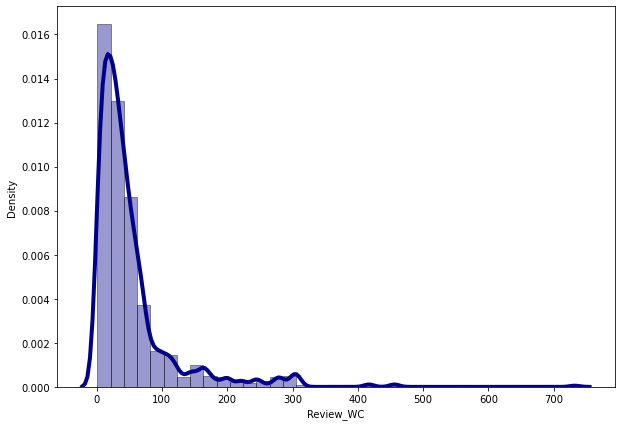

In [13]:
# Density plot and histogram of all word count
plt.figure(figsize=(10,7))
sns.distplot(df['Review_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

In [14]:
# Creating column for character counts in the review text
df['Review_CC'] = df['Product_Review'].str.len()
df[['Review_CC','Product_Review']].head(10)

,Review_CC,Product_Review
0,249,great sound quality bass month use get break ...
1,1010,big updateit break along right hinge wear norm...
2,366,premium quality product boatlifestyle professi...
3,1929,boat rockerz line boat super cheap lineup budg...
4,88,material poor quality service also good produc...
5,315,super comfortable premium look headphone beaut...
6,168,never see fragile headphone one deliver produc...
7,184,poor build quality one side headphone break no...
8,585,decentpros light weight make plastic battery s...
9,178,buy month back break plastic much flexible pr...


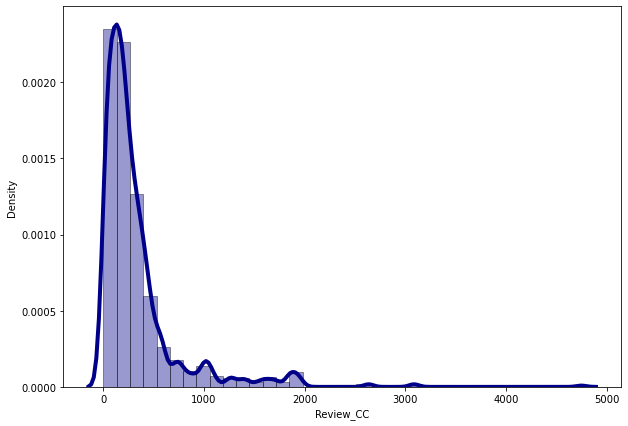

In [15]:
# Density plot and histogram of all character count
plt.figure(figsize=(10,7))
sns.distplot(df['Review_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

In [16]:
# Applying zscore to remove outliers
z_score = zscore(df[['Review_WC']])
abs_z_score = np.abs(z_score)
filtering_entry = (abs_z_score < 3).all(axis = 1)
df = df[filtering_entry]
print("We have {} Rows and {} Columns in our dataframe after removing outliers".format(df.shape[0], df.shape[1]))

We have 46350 Rows and 5 Columns in our dataframe after removing outliers


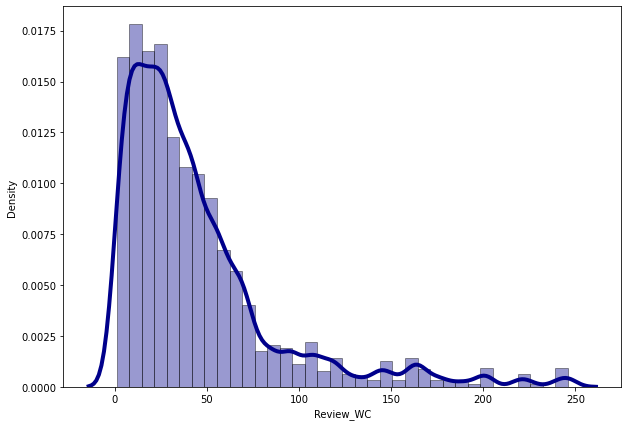

In [17]:
# Density plot and histogram of all word count
plt.figure(figsize=(10,7))
sns.distplot(df['Review_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

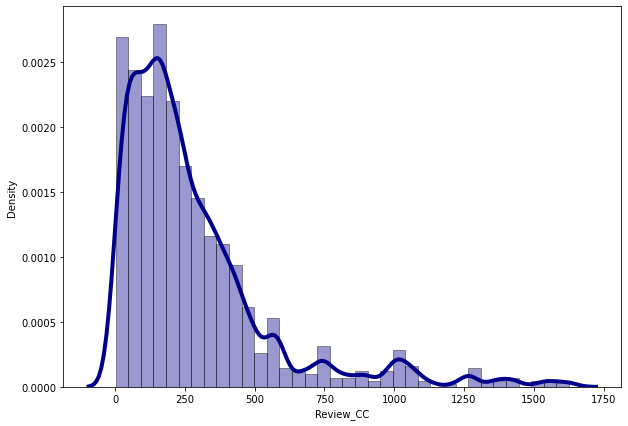

In [18]:
# Density plot and histogram of all character count
plt.figure(figsize=(10,7))
sns.distplot(df['Review_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

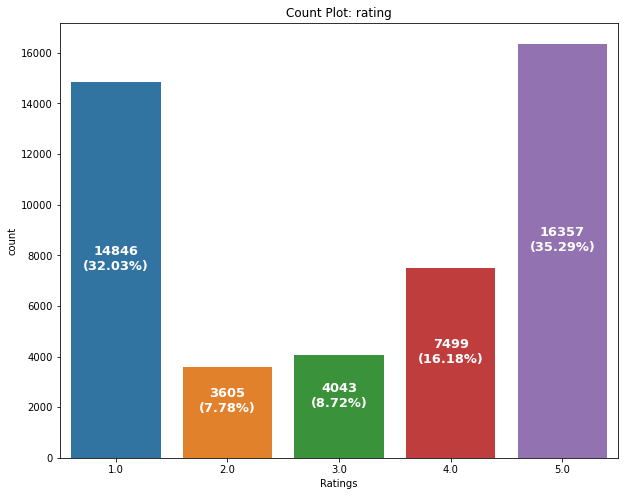

In [19]:
# Checking the ratings column details using count plot
x = 'Ratings'
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.countplot(x=x,data=df,ax=ax)
p=0
for i in ax.patches:
    q = i.get_height()/2
    val = i.get_height()
    ratio = round(val*100/len(df),2)
    prn = f"{val}\n({ratio}%)"
    ax.text(p,q,prn,ha="center",color="white",rotation=0,fontweight="bold",fontsize="13")
    p += 1
    
plt.title("Count Plot: rating")
plt.show()

5.0    16357
1.0    14846
4.0     7499
3.0     4043
2.0     3605
Name: Ratings, dtype: int64


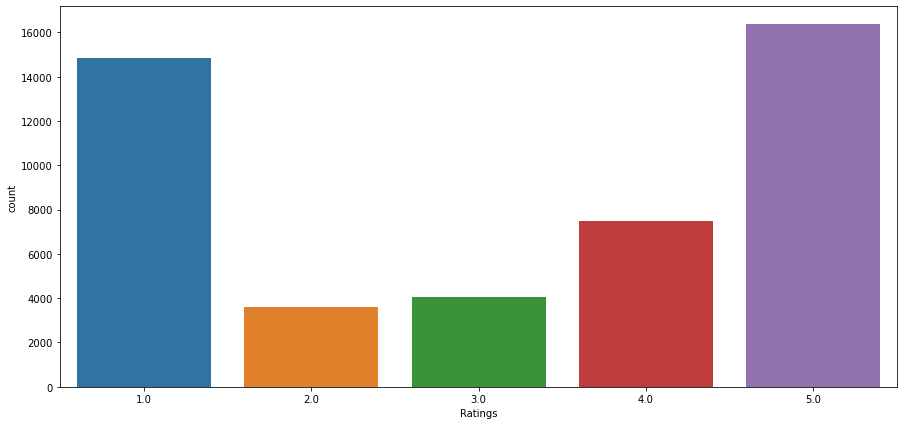

In [20]:
# Checking the count of target column values
plt.figure(figsize=(15,7))
sns.countplot(df['Ratings'])
print(df.Ratings.value_counts())
plt.show()

In [21]:
# shuffling the entire data set
df = df.sample(frac=1).reset_index(drop=True)
df

,Unnamed: 0,Product_Review,Ratings,Review_WC,Review_CC
0,12804,boat bass head really live name provide amazin...,4.0,51,319
1,13410,great sound quality bass month use get break ...,1.0,41,249
2,16089,month sound come right sideleft workingafter r...,1.0,33,233
3,41992,battery issue si amcard slot nd work call amaz...,1.0,42,268
4,5855,use less one week one headphone wire come mic ...,1.0,38,263
...,...,...,...,...,...
46345,26138,laptop good fast ghz mention correct say ghz ...,4.0,31,171
46346,13971,get prime day exclusive sale r u cant get goo...,1.0,98,576
46347,16812,headphone great doubt thatbut start issue try ...,1.0,52,362
46348,7955,buy look quality bassheads like lot cable len...,3.0,35,211


In [22]:
# Select data from every Ratings category
df1 = df[df['Ratings']==1][0:3605]
df2 = df[df['Ratings']==2][0:3605]
df3 = df[df['Ratings']==3][0:3605]
df4 = df[df['Ratings']==4][0:3605]
df5 = df[df['Ratings']==5][0:3605]

# Combining all the dataframes into one and shuffling them again
df = pd.concat([df1,df2,df3,df4,df5], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df

,Unnamed: 0,Product_Review,Ratings,Review_WC,Review_CC
0,34950,first problem activate m office call lenovo s...,3.0,31,205
1,10109,overdid bass virtually treble singer voice get...,3.0,36,235
2,19642,receive second hand headphone,1.0,4,29
3,1083,allow write technical accurate review amaze bo...,4.0,71,500
4,26150,receive yesterday prompt delivery amazon expe...,4.0,162,1066
...,...,...,...,...,...
18020,29685,waited week receive laptop review give feedbac...,3.0,132,826
18021,15160,purchase boat earphone month agohere amsharing...,3.0,106,739
18022,45510,photo clear amnot satisfy camera everything ok...,5.0,9,62
18023,6003,buy sept amnot satisfied purchase dont get wro...,2.0,55,313


4.0    3605
2.0    3605
3.0    3605
5.0    3605
1.0    3605
Name: Ratings, dtype: int64


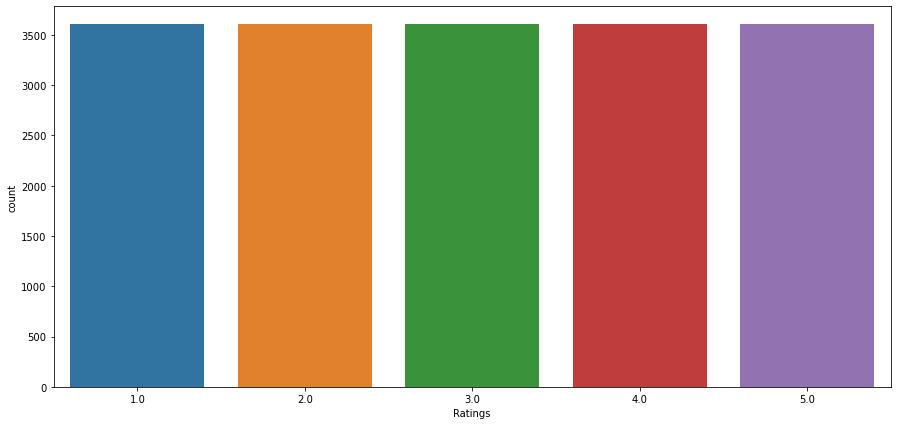

In [23]:
# lets Check the count of target column again to confirm the balance with a visual
plt.figure(figsize=(15,7))
sns.countplot(df['Ratings'])
print(df.Ratings.value_counts())
plt.show()

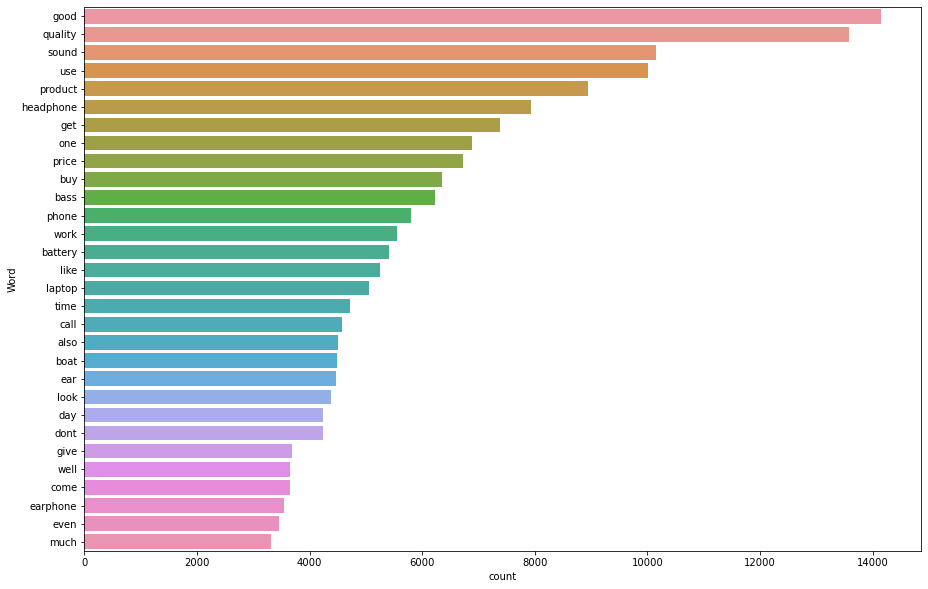

In [24]:
# Function to plot most frequent terms in our Review column
def freq_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    # selecting top 30 most frequent words
    dt = words_df.nlargest(columns='count', n=terms)
    plt.figure(figsize=(15,10))
    ax = sns.barplot(data=dt, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()
    
freq_words(df['Product_Review'])

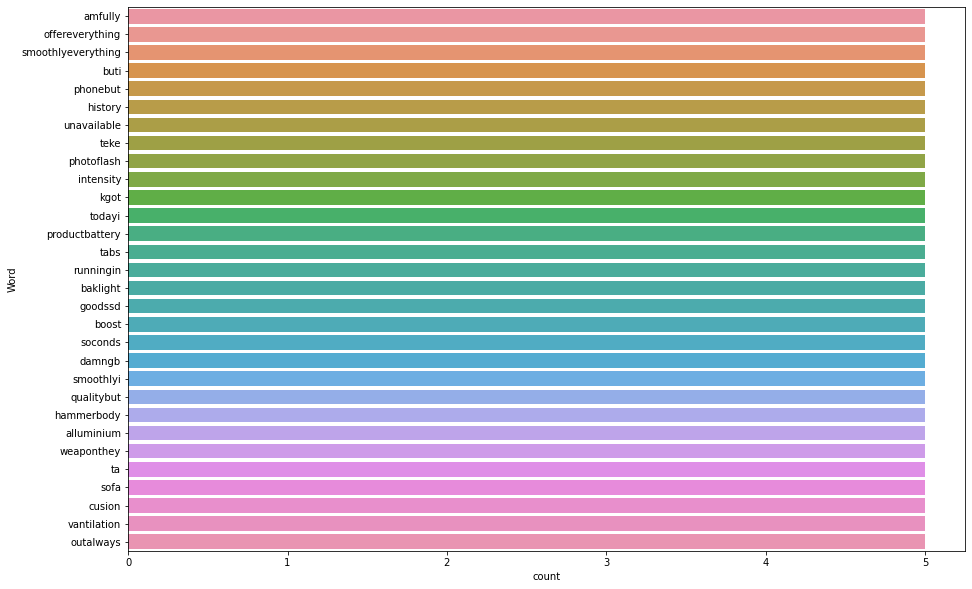

In [25]:
# Function to plot least frequent terms in our Review column
def rare_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    # selecting top 30 least freq rare words
    dt = words_df.nsmallest(columns='count', n=terms)
    plt.figure(figsize=(15,10))
    ax = sns.barplot(data=dt, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()
    
rare_words(df['Product_Review']) 

In [26]:
# Separating features and labels here
x = df['Product_Review']
y = df['Ratings']

In [27]:
# Using the n_gram tfidf vectorizer (Word vectors)
word_vectorizer = TfidfVectorizer(sublinear_tf = True,
                                  strip_accents = 'unicode',
                                  analyzer = 'word',
                                  token_pattern = r'\w{1,}',
                                  stop_words = 'english',
                                  ngram_range = (1,3),
                                  max_features = 100000)
word_vectorizer.fit(x)
train_word_features = word_vectorizer.transform(x)

# Character vectors
char_vectorizer = TfidfVectorizer(sublinear_tf = True,
                                  strip_accents = 'unicode',
                                  analyzer = 'char',
                                  stop_words = 'english',
                                  ngram_range = (2,6),
                                  max_features = 50000)
char_vectorizer.fit(x)
train_char_features = char_vectorizer.transform(x)

# I will now combine both word vectors and character vectors as input for our model
train_features = hstack([train_char_features, train_word_features])

In [28]:
state = 42
x_train, x_test, y_train, y_test = train_test_split(train_features, y, test_size = 0.30, random_state = state)

# Lets check the shapes of traning and test data
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (12617, 87064)
x_test (5408, 87064)
y_train (12617,)
y_test (5408,)


In [29]:
# Defining the Classification Machine Learning Algorithms
rf = RandomForestClassifier()
lr = LogisticRegression(solver='lbfgs')
svc = LinearSVC()

# Creating a function to train and test the model with evaluation metrics
def BuiltModel(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, pred)*100
    print(f"ACCURACY SCORE PERCENTAGE:", accuracy)
    # Confusion matrix and Classification report
    print(f"CLASSIFICATION REPORT: \n {classification_report(y_test, pred)}")
    print(f"CONFUSION MATRIX: \n {confusion_matrix(y_test, pred)}\n")
    print("-"*120)
    print("\n")

In [30]:
for model in [lr,svc]:
    BuiltModel(model)

******************************LogisticRegression******************************
ACCURACY SCORE PERCENTAGE: 87.20414201183432
CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

         1.0       0.83      0.87      0.85      1029
         2.0       0.88      0.91      0.89      1072
         3.0       0.95      0.91      0.93      1144
         4.0       0.87      0.82      0.84      1023
         5.0       0.83      0.85      0.84      1140

    accuracy                           0.87      5408
   macro avg       0.87      0.87      0.87      5408
weighted avg       0.87      0.87      0.87      5408

CONFUSION MATRIX: 
 [[ 898   28   18   26   59]
 [  26  974   12   31   29]
 [  18   24 1036   31   35]
 [  57   45   12  840   69]
 [  87   37    7   41  968]]

------------------------------------------------------------------------------------------------------------------------


******************************LinearSVC******************************
ACCURAC

In [31]:
# I am checking cross-validation score only for those algorithms which are giving us better accuracies

def cross_val(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    scores = cross_val_score(model,train_features,y, cv = 3).mean()*100
    print("Cross validation score:", scores)
    print("\n")

In [32]:
for model in [lr,svc]:
    cross_val(model)

******************************LogisticRegression******************************
Cross validation score: 87.06795831552272


******************************LinearSVC******************************
Cross validation score: 87.05131384148811




In [33]:
#logistic regression gives higher score
import pickle
filename='Rating_Prediction.pickle'
pickle.dump(lr,open(filename,'wb'))